<a href="https://colab.research.google.com/github/aifajar/eratani_ml_path/blob/main/Forecast_model_for_Tavg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
url = '/content/df_Tavg.csv'

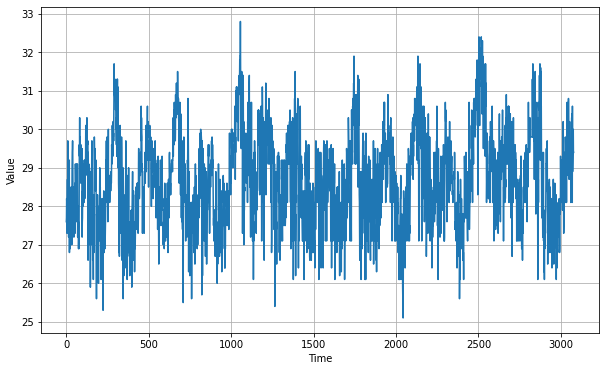

In [4]:
import csv
time_step = []
temps = []

with open(url) as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 2300
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2300,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
9/9 [==============================] - 7s 321ms/step - loss: 43.6958 - mae: 44.1926
Epoch 2/100
9/9 [==============================] - 3s 318ms/step - loss: 41.9770 - mae: 42.4739
Epoch 3/100
9/9 [==============================] - 3s 319ms/step - loss: 39.1464 - mae: 39.6429
Epoch 4/100
9/9 [==============================] - 3s 317ms/step - loss: 35.2411 - mae: 35.7373
Epoch 5/100
9/9 [==============================] - 3s 316ms/step - loss: 30.2406 - mae: 30.7379
Epoch 6/100
9/9 [==============================] - 3s 320ms/step - loss: 24.7622 - mae: 25.2596
Epoch 7/100
9/9 [==============================] - 3s 322ms/step - loss: 20.3482 - mae: 20.8463
Epoch 8/100
9/9 [==============================] - 3s 318ms/step - loss: 16.1242 - mae: 16.6228
Epoch 9/100
9/9 [==============================] - 3s 333ms/step - loss: 11.7570 - mae: 12.2552
Epoch 10/100
9/9 [==============================] - 3s 320ms/step - loss: 7.2954 - mae: 7.7881
Epoch 11/100
9/9 [=======================

(1e-08, 0.0001, 0.0, 60.0)

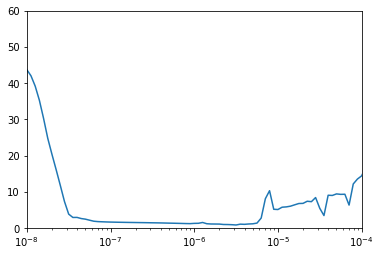

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
23/23 [==============================] - 6s 124ms/step - loss: 10.4403 - mae: 10.9337
Epoch 2/150
23/23 [==============================] - 3s 121ms/step - loss: 1.3994 - mae: 1.8401
Epoch 3/150
23/23 [==============================] - 3s 122ms/step - loss: 0.7573 - mae: 1.1701
Epoch 4/150
23/23 [==============================] - 3s 121ms/step - loss: 0.6211 - mae: 1.0230
Epoch 5/150
23/23 [==============================] - 3s 122ms/step - loss: 0.5952 - mae: 0.9931
Epoch 6/150
23/23 [==============================] - 3s 123ms/step - loss: 0.5651 - mae: 0.9594
Epoch 7/150
23/23 [==============================] - 3s 121ms/step - loss: 0.6125 - mae: 1.0128
Epoch 8/150
23/23 [==============================] - 3s 121ms/step - loss: 0.5486 - mae: 0.9418
Epoch 9/150
23/23 [==============================] - 3s 121ms/step - loss: 0.4943 - mae: 0.8807
Epoch 10/150
23/23 [==============================] - 3s 123ms/step - loss: 0.4761 - mae: 0.8591
Epoch 11/150
23/23 [=================

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

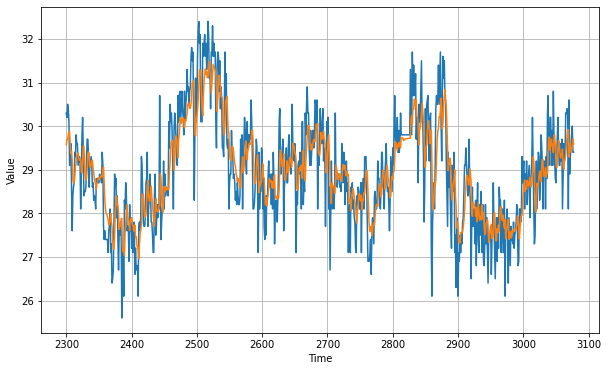

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.57470536

In [15]:
for n in range(28):
  print(rnn_forecast[n])

29.574347
29.689827
29.695337
29.786074
29.873505
29.880508
29.581047
29.367292
29.422443
29.215086
28.79318
28.695375
28.714907
28.835518
29.079231
29.141647
29.325182
29.37929
29.389631
29.277813
29.213356
29.239672
29.239803
28.936995
28.929562
29.21052
29.541763
29.533398
